**TODO**: 
* Evaluation at different granularity 


In [1]:
# Re-import necessary libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image

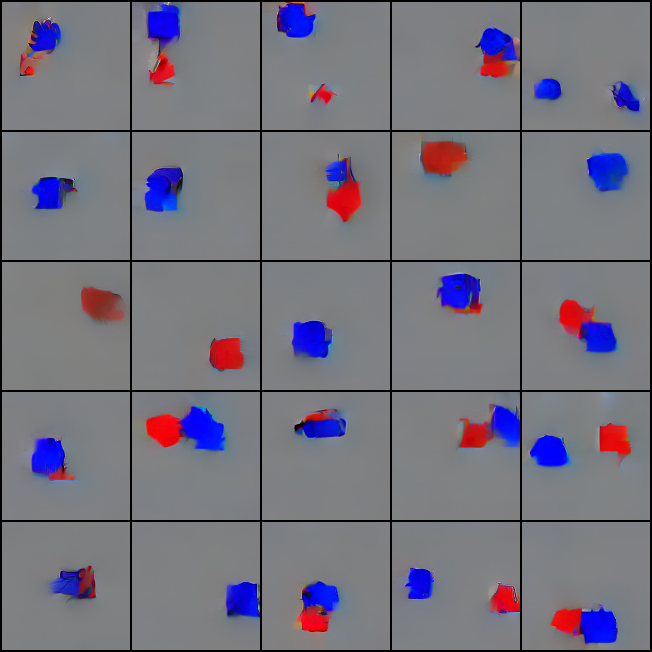

In [52]:
# Load the local image
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]

sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_nano_pilot/samples"
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


def load_image(step_num, prompt_id, sample_root=sample_root):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=sample_root):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


prompt_id = 2
step_num = 10000
image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
image = Image.open(image_path)
image

### Detect object and classify

In [24]:
def find_classify_objects(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    classified_objects_df
    return classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)


8 red_is_above_blue


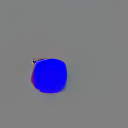

   Object   Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (13, 4, 240)      (50, 76)  937.5         1024.0


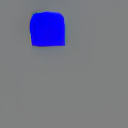

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (12, 5, 242)      (47, 28)  1074.0         1024.0


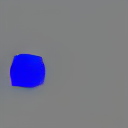

   Object   Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (13, 8, 239)      (28, 70)  963.0         1024.0


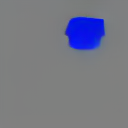

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (11, 26, 226)      (85, 33)  996.0     804.247719


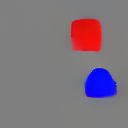

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (229, 22, 19)      (86, 35)  876.0    1024.000000
1       1  Circle  (13, 14, 246)     (100, 83)  717.5     804.247719


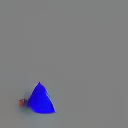

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       2  Rectangle  (30, 17, 221)      (43, 98)  450.5         1024.0


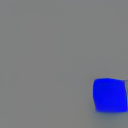

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (11, 16, 232)     (110, 95)  981.5         1024.0


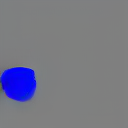

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (13, 11, 236)      (18, 84)  925.0     804.247719


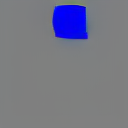

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (6, 6, 237)      (70, 22)  1018.5         1024.0


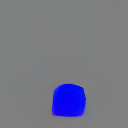

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (14, 10, 240)     (69, 100)  932.0         1024.0


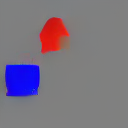

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (216, 31, 22)      (54, 35)  623.0     804.247719
1       1  Square  (19, 11, 239)      (23, 80)  953.5    1024.000000


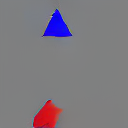

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1    Square  (206, 25, 33)     (47, 114)  399.5    1024.000000
1       1  Triangle   (20, 8, 239)    (57, 22.0)  373.5     443.405007


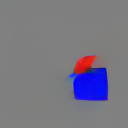

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1     Square  (215, 35, 28)      (86, 64)  190.0         1024.0
1       1  Rectangle  (15, 16, 235)      (88, 85)  889.5         1024.0


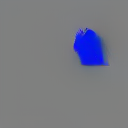

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (14, 29, 226)      (91, 47)  768.0         1024.0


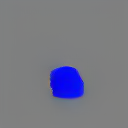

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (14, 15, 234)      (67, 82)  864.0         1024.0


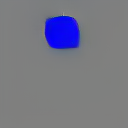

   Object   Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (12, 8, 237)      (62, 31)  879.0     804.247719


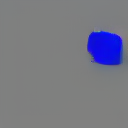

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (15, 17, 225)     (105, 47)  893.5     804.247719


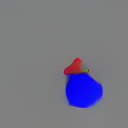

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (15, 11, 238)      (84, 90)  937.5     804.247719


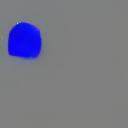

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (17, 13, 235)      (25, 40)  948.0     804.247719


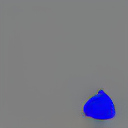

   Object   Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (14, 9, 230)     (99, 104)  583.5         1024.0


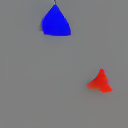

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (206, 41, 29)     (100, 81)  265.5    1024.000000
1       1  Circle  (17, 13, 232)      (56, 20)  556.5     804.247719


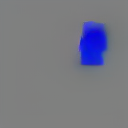

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (24, 32, 211)      (92, 43)  862.5     804.247719


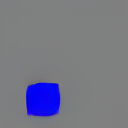

   Object   Shape  Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (9, 6, 239)      (43, 99)  979.5         1024.0


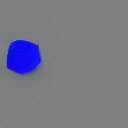

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (19, 16, 233)      (24, 57)  867.5     804.247719


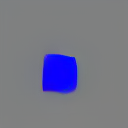

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (17, 9, 245)      (60, 73)  1194.5         1024.0


In [25]:
# image = load_image(step_num, prompt_id)
# display(image)
step_num = 25000
prompt_id = 8
subimages = load_image_grid(step_num, prompt_id)
print(prompt_id, prompt_names[prompt_id])
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)


In [5]:
# def eval_from_df(df, target_object_info):
    # check if the target object is in the df
    


In [6]:
import pandas as pd

def evaluate_triangle_positions(df, MARGIN=25):
    """ blue_triangle_is_above_red_triangle
    Evaluates if a blue-dominant triangle is above a red-dominant triangle in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.

    Returns:
    bool: True if a blue-dominant triangle is above a red-dominant triangle, False otherwise.
    """
    # Validate input
    if df.empty:
        return False, "no object"
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        # return False, "no object"
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")
    # Extract triangles
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255-MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255-MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)
    # Identify red-dominant and blue-dominant triangles
    red_triangle = df.query("is_red == True and Shape == 'Triangle'")
    blue_triangle = df.query("is_blue == True and Shape == 'Triangle'")
    if red_triangle.empty:
        return False, "missing red triangle"
    if blue_triangle.empty:
        return False, "missing blue triangle"
    # Compare the y-coordinates (assuming y increases downwards)
    red_y = red_triangle['Center (x, y)'].iloc[0][1]
    red_x = red_triangle['Center (x, y)'].iloc[0][0]
    blue_y = blue_triangle['Center (x, y)'].iloc[0][1]
    blue_x = blue_triangle['Center (x, y)'].iloc[0][0]
    above = blue_y < red_y # and abs(blue_x - red_x) < 10
    if above:
        return True, "correct"
    else:
        return False, "spatial relation incorrect" # and abs(blue_x - red_x) < 10

In [53]:
import pandas as pd

def identity_spatial_relation(x1, y1, x2, y2):
    dx = x1 - x2  # Positive means shape1 is to the right
    dy = y1 - y2  # Positive means shape1 is lower
    # Define thresholds for "directly" above/below/left/right
    threshold = 5  # pixels
    if abs(dx) <= threshold:  # Roughly aligned vertically
        if dy < 0:
            observed_relation = 'above'
        else:
            observed_relation = 'below'
    elif abs(dy) <= threshold:  # Roughly aligned horizontally
        if dx < 0:
            observed_relation = 'left'
        else:
            observed_relation = 'right'
    else:  # Diagonal relationship
        if dx < 0 and dy < 0:
            observed_relation = 'upper_left'
        elif dx < 0 and dy > 0:
            observed_relation = 'lower_left'
        elif dx > 0 and dy < 0:
            observed_relation = 'upper_right'
        else:  # dx > 0 and dy > 0
            observed_relation = 'lower_right'
    return observed_relation


'''def evaluate_parametric_relation(df, scene_info, MARGIN=25):
    """
    Evaluates parametric relationships between objects in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.
    scene_info (dict): Dictionary specifying the relationship details (shape, color, and spatial relationship).
    MARGIN (int): Tolerance for identifying dominant colors.

    Returns:
    dict: Dictionary with keys for overall correctness, shape match, color match, and spatial relationship match.
    """
    # Validate input
    if df.empty:
        return {"overall": False, "shape": False, "color": False, "spatial_relationship": False, "reason": "no object"}
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")

    shape1 = scene_info["shape1"]
    shape2 = scene_info["shape2"]
    color1 = scene_info["color1"]
    color2 = scene_info["color2"]
    spatial_relationship = scene_info["spatial_relationship"]

    # Extract triangles
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255 - MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255 - MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)

    # Identify red-dominant and blue-dominant triangles
    mask1 = np.ones(len(df), dtype=bool)
    if shape1 is not None:
        mask1 = mask1 & (df['Shape'] == shape1)
    if color1 is not None:
        if color1 == "red":
            mask1 = mask1 & (df['is_red'] == True)
        elif color1 == "blue":
            mask1 = mask1 & (df['is_blue'] == True)
    obj1_df = df[mask1]

    if obj1_df.empty:
        return {"overall": False, "shape": False, "color": False, "spatial_relationship": False, "reason": "missing object 1"}

    mask2 = np.ones(len(df), dtype=bool)
    if shape2 is not None:
        mask2 = mask2 & (df['Shape'] == shape2)
    if color2 is not None:
        if color2 == "red":
            mask2 = mask2 & (df['is_red'] == True)
        elif color2 == "blue":
            mask2 = mask2 & (df['is_blue'] == True)
    obj2_df = df[mask2]

    if obj2_df.empty:
        return {"overall": False, "shape": False, "color": False, "spatial_relationship": False, "reason": "missing object 2"}

    # Shape and color checks
    shape_correct = True
    color_correct = True

    if shape1 is not None and (df['Shape'] != shape1).all():
        shape_correct = False
    if shape2 is not None and (df['Shape'] != shape2).all():
        shape_correct = False

    if color1 == "red" and not obj1_df['is_red'].all():
        color_correct = False
    if color2 == "red" and not obj2_df['is_red'].all():
        color_correct = False
    if color1 == "blue" and not obj1_df['is_blue'].all():
        color_correct = False
    if color2 == "blue" and not obj2_df['is_blue'].all():
        color_correct = False

    # Compare spatial relationship
    if len(obj1_df) == 1 and len(obj2_df) == 1:
        x1, y1 = obj1_df['Center (x, y)'].iloc[0]
        x2, y2 = obj2_df['Center (x, y)'].iloc[0]
        observed_relation = identity_spatial_relation(x1, y1, x2, y2)
        spatial_correct = spatial_relationship == observed_relation
    elif len(obj1_df) == len(obj2_df) == 2 and obj1_df.equals(obj2_df):
        x1, y1 = obj1_df['Center (x, y)'].iloc[0]
        x2, y2 = obj1_df['Center (x, y)'].iloc[1]
        observed_relation1 = identity_spatial_relation(x1, y1, x2, y2)
        observed_relation2 = identity_spatial_relation(x2, y2, x1, y1)
        spatial_correct = spatial_relationship in [observed_relation1, observed_relation2]
    else:
        spatial_correct = False

    overall_correct = shape_correct and color_correct and spatial_correct
    return {
        "overall": overall_correct,
        "shape": shape_correct,
        "color": color_correct,
        "spatial_relationship": spatial_correct,
        "reason": "correct" if overall_correct else "relation mismatch or missing attributes"
    }'''

def evaluate_parametric_relation(df, scene_info, MARGIN=25):
    """
    Evaluates parametric relationships between objects in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.
    scene_info (dict): Dictionary specifying the relationship details (shape, color, and spatial relationship).
    MARGIN (int): Tolerance for identifying dominant colors.

    Returns:
    dict: Dictionary with keys for overall correctness, shape match, color match, and spatial relationship match.
    """
    # Validate input
    if df.empty:
        return {"overall": False, "shape": False, "color": False, "spatial_relationship": False, "reason": "no object"}
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")

    shape1 = scene_info["shape1"]
    shape2 = scene_info["shape2"]
    color1 = scene_info["color1"]
    color2 = scene_info["color2"]
    spatial_relationship = scene_info["spatial_relationship"]

    # Add color classifications to the DataFrame
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255 - MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255 - MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)

    # Check for object existence
    obj1 = df[
        ((df["Shape"] == shape1) if shape1 else True) &
        ((df["is_red"] if color1 == "red" else True) if color1 else True) &
        ((df["is_blue"] if color1 == "blue" else True) if color1 else True)
    ]
    obj2 = df[
        ((df["Shape"] == shape2) if shape2 else True) &
        ((df["is_red"] if color2 == "red" else True) if color2 else True) &
        ((df["is_blue"] if color2 == "blue" else True) if color2 else True)
    ]

    # Evaluate individual correctness
    shape_correct = (
        (shape1 is None or any(df["Shape"] == shape1)) and
        (shape2 is None or any(df["Shape"] == shape2))
    )
    color_correct = (
        (color1 is None or (color1 == "red" and any(df["is_red"])) or (color1 == "blue" and any(df["is_blue"]))) and
        (color2 is None or (color2 == "red" and any(df["is_red"])) or (color2 == "blue" and any(df["is_blue"])))
    )

    # Spatial relationship correctness
    if len(obj1) == 1 and len(obj2) == 1:
        x1, y1 = obj1["Center (x, y)"].iloc[0]
        x2, y2 = obj2["Center (x, y)"].iloc[0]
        observed_relation = identity_spatial_relation(x1, y1, x2, y2)
        spatial_correct = spatial_relationship == observed_relation
    else:
        spatial_correct = False

    # Overall correctness
    overall_correct = shape_correct and color_correct and spatial_correct

    return {
        "overall": overall_correct,
        "shape": shape_correct,
        "color": color_correct,
        "spatial_relationship": spatial_correct,
    }


scene_info_collection = {'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_circle_is_above_and_to_the_right_of_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "upper_right"},
                        'blue_circle_is_above_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "above"},
                        'blue_square_is_to_the_right_of_red_circle':  {"color1": "blue", "shape1": "Square", "color2": "red", "shape2": "Circle", "spatial_relationship": "right"},
                        'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_triangle_is_to_the_upper_left_of_red_square':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Square", "spatial_relationship": "upper_left"},
                        'circle_is_below_red_square':  {"color1": None, "shape1": "Circle", "color2": "red", "shape2": "Square", "spatial_relationship": "below"},
                        'red_circle_is_above_square':  {"color1": "red", "shape1": "Circle", "color2": None, "shape2": "Square", "spatial_relationship": "above"},
                        'red_circle_is_to_the_left_of_blue_square':  {"color1": "red", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "left"},
                        'red_is_above_blue':  {"color1": "red", "shape1": None, "color2": "blue", "shape2": None, "spatial_relationship": "above"},  # TODO: check 
                        'red_is_to_the_left_of_red':  {"color1": "red", "shape1": None, "color2": "red", "shape2": None, "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_above_and_to_the_right_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_right"},
                        'triangle_is_above_red_circle':  {"color1": None, "shape1": "Triangle", "color2": "red", "shape2": "Circle", "spatial_relationship": "above"},
                        'triangle_is_to_the_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "left"},
                        'triangle_is_to_the_left_of_triangle':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Triangle", "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_to_the_upper_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_left"},
                        }


def eval_func_factory(prompt_name):
    return lambda df: evaluate_parametric_relation(df, scene_info_collection[prompt_name])


0 blue_circle_is_above_and_to_the_right_of_blue_square
{'color1': 'blue', 'shape1': 'Circle', 'color2': 'blue', 'shape2': 'Square', 'spatial_relationship': 'upper_right'}


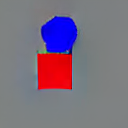

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (233, 1, 8)      (54, 72)  1120.0    1024.000000
1       1  Circle  (7, 1, 242)      (59, 34)   941.5     804.247719
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


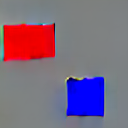

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       3  Rectangle  (238, 2, 7)      (29, 43)  1645.5         1024.0
1       1     Square  (4, 3, 247)      (85, 96)  1270.0         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


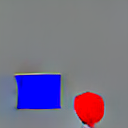

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       2     Circle  (241, 3, 4)     (89, 109)   715.5     804.247719
1       5  Rectangle  (3, 2, 249)      (38, 91)  1391.5    1024.000000
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


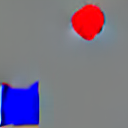

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       4  Circle  (245, 5, 11)      (88, 22)   779.5     804.247719
1       2  Circle  (8, 10, 243)     (20, 103)  1243.0     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


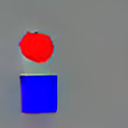

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       2  Circle  (244, 8, 13)      (36, 48)   745.5     804.247719
1       1  Square   (8, 2, 246)      (39, 94)  1253.0    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


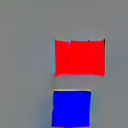

   Object      Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       4  Rectangle  (248, 3, 10)      (79, 58)  1586.5         1024.0
1       1     Square   (2, 1, 244)     (71, 109)  1230.0         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


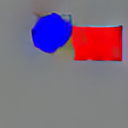

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Rectangle  (233, 6, 9)      (96, 42)  1513.5    1024.000000
1       3     Circle  (5, 1, 245)      (52, 33)  1046.0     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


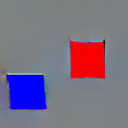

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       2  Square  (246, 1, 4)      (87, 59)  1130.5         1024.0
1       1  Square  (3, 1, 251)      (27, 91)  1152.5         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


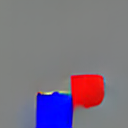

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       4  Square  (231, 13, 14)      (87, 91)   908.0         1024.0
1       1  Square    (4, 5, 248)     (53, 110)  1105.5         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


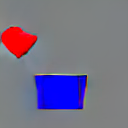

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       3     Circle  (249, 3, 6)      (19, 41)   622.0     804.247719
1       1  Rectangle  (7, 1, 241)      (60, 92)  1487.5    1024.000000
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


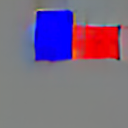

   Object      Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       2  Rectangle  (232, 18, 20)      (95, 41)  1397.0    1024.000000
1       5     Circle   (10, 6, 241)      (50, 35)  1763.5     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


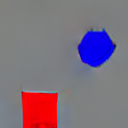

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (242, 2, 6)     (40, 110)  1149.0    1024.000000
1       5  Circle  (7, 2, 234)      (96, 48)   887.0     804.247719
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


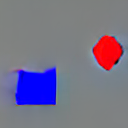

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle  (247, 4, 12)     (108, 52)   611.5     804.247719
1       1  Square  (11, 9, 248)      (36, 86)  1325.0    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


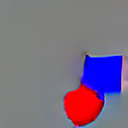

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle    (243, 1, 5)     (83, 106)   960.0     804.247719
1       5  Circle  (14, 11, 245)     (102, 87)  1367.0     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


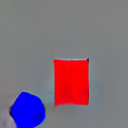

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Rectangle  (242, 3, 8)      (71, 82)  1431.5    1024.000000
1       1     Circle  (4, 3, 243)     (28, 110)   902.0     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


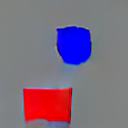

   Object      Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Rectangle  (233, 5, 10)     (47, 104)  1386.5         1024.0
1       7  Rectangle   (4, 3, 245)      (74, 46)  1036.5         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


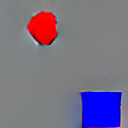

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       4  Circle  (244, 3, 5)      (42, 28)   638.5     804.247719
1       1  Square  (5, 3, 245)    (101, 109)  1285.0    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


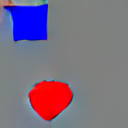

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle   (249, 2, 5)     (50, 100)  1133.5     804.247719
1      11  Square  (8, 10, 247)      (27, 21)  1190.5    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


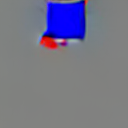

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle  (212, 42, 44)      (52, 43)   122.5     804.247719
1       4  Square    (8, 5, 240)      (63, 19)  1172.5    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


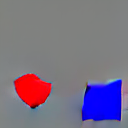

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       4  Circle   (247, 3, 9)      (33, 90)   766.5     804.247719
1       3  Square  (11, 8, 246)     (102, 99)  1293.5    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


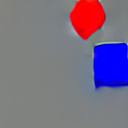

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle  (246, 4, 9)      (87, 20)   961.0     804.247719
1       1  Circle  (6, 5, 243)     (110, 66)  1364.0     804.247719
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


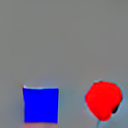

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       2  Circle  (246, 6, 12)    (103, 101)   957.5     804.247719
1       6  Square   (8, 7, 246)     (41, 104)  1115.0    1024.000000
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


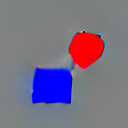

   Object      Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1     Square  (250, 2, 7)      (86, 50)   867.5         1024.0
1       2  Rectangle  (6, 6, 249)      (51, 85)  1264.5         1024.0
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


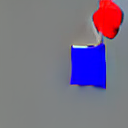

   Object      Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       7     Circle  (246, 6, 12)     (107, 19)   715.5     804.247719
1       1  Rectangle  (13, 8, 248)      (88, 66)  1295.5    1024.000000
{'overall': False, 'shape': False, 'color': True, 'spatial_relationship': False}


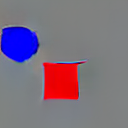

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (237, 4, 8)      (61, 81)  1135.0    1024.000000
1       5  Circle  (5, 3, 245)      (19, 45)   957.5     804.247719
{'overall': False, 'shape': True, 'color': True, 'spatial_relationship': False}


In [62]:
step_num = 50000
prompt_id = 0
subimages = load_image_grid(step_num, prompt_id)
print(prompt_id, prompt_names[prompt_id])
scene_info = scene_info_collection[prompt_names[prompt_id]]
print(scene_info)

eval_func = lambda df: evaluate_parametric_relation(df, scene_info)
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)
    print(eval_func(classified_objects_df))

In [54]:
from tqdm.auto import trange, tqdm
# image = load_image(step_num, prompt_id)
eval_score = []
object_df_col = []

for prompt_id in range(len(prompt_names)):
    print(prompt_id, prompt_names[prompt_id])
    eval_func = eval_func_factory(prompt_names[prompt_id])
    
    for step_num in trange(2500, 160000, 2500):
        subimages = load_image_grid(step_num, prompt_id)
        
        for si, subimage in enumerate(subimages):
            classified_objects_df = find_classify_objects(subimage)
            object_df_col.append(classified_objects_df)
            
            eval_result = eval_func(classified_objects_df)  # Returns a dictionary
            eval_score.append({
                "step_num": step_num,
                "sample_id": si,
                "prompt_id": prompt_id,
                "overall": eval_result["overall"],
                "shape": eval_result["shape"],
                "color": eval_result["color"],
                "spatial_relationship": eval_result["spatial_relationship"],
            })

# Convert the list of dictionaries to a DataFrame
eval_score_df = pd.DataFrame(eval_score)


0 blue_circle_is_above_and_to_the_right_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

1 blue_circle_is_above_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

2 blue_square_is_to_the_right_of_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

3 blue_triangle_is_above_red_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

4 blue_triangle_is_to_the_upper_left_of_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

5 circle_is_below_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

6 red_circle_is_above_square


  0%|          | 0/63 [00:00<?, ?it/s]

7 red_circle_is_to_the_left_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

8 red_is_above_blue


  0%|          | 0/63 [00:00<?, ?it/s]

9 red_is_to_the_left_of_red


  0%|          | 0/63 [00:00<?, ?it/s]

10 triangle_is_above_and_to_the_right_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

11 triangle_is_above_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

12 triangle_is_to_the_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

13 triangle_is_to_the_left_of_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

14 triangle_is_to_the_upper_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

In [58]:
eval_score_df

,step_num,sample_id,prompt_id,overall,shape,color,spatial_relationship
0,2500,0,0,False,False,False,False
1,2500,1,0,False,False,False,False
2,2500,2,0,False,False,False,False
3,2500,3,0,False,False,False,False
4,2500,4,0,False,False,False,False
...,...,...,...,...,...,...,...
23620,157500,20,14,False,False,True,False
23621,157500,21,14,True,True,True,True
23622,157500,22,14,False,True,True,False
23623,157500,23,14,False,False,True,False


In [57]:
import pickle
save_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_nano_pilot/sample_eval"
with open(f"{save_dir}/eval_score.pkl", "wb") as f:
    pickle.dump(eval_score_df, f)

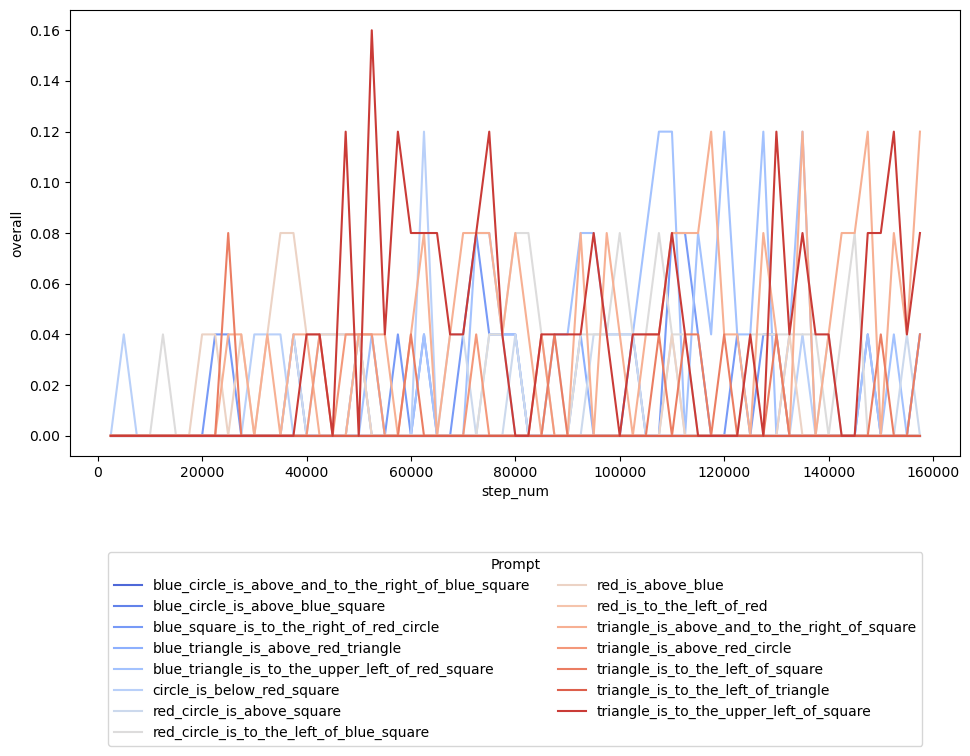

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data and prepare the DataFrame for plotting
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"overall": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])

# Create the plot
plt.figure(figsize=(10, 8))
sns.lineplot(data=score_tab, x="step_num", y="overall", hue="prompt_name", palette="coolwarm")

# Adjust the legend position to below the plot
plt.legend(title="Prompt", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)  # Adjust `ncol` as needed for more compact layout
plt.tight_layout()
plt.show()


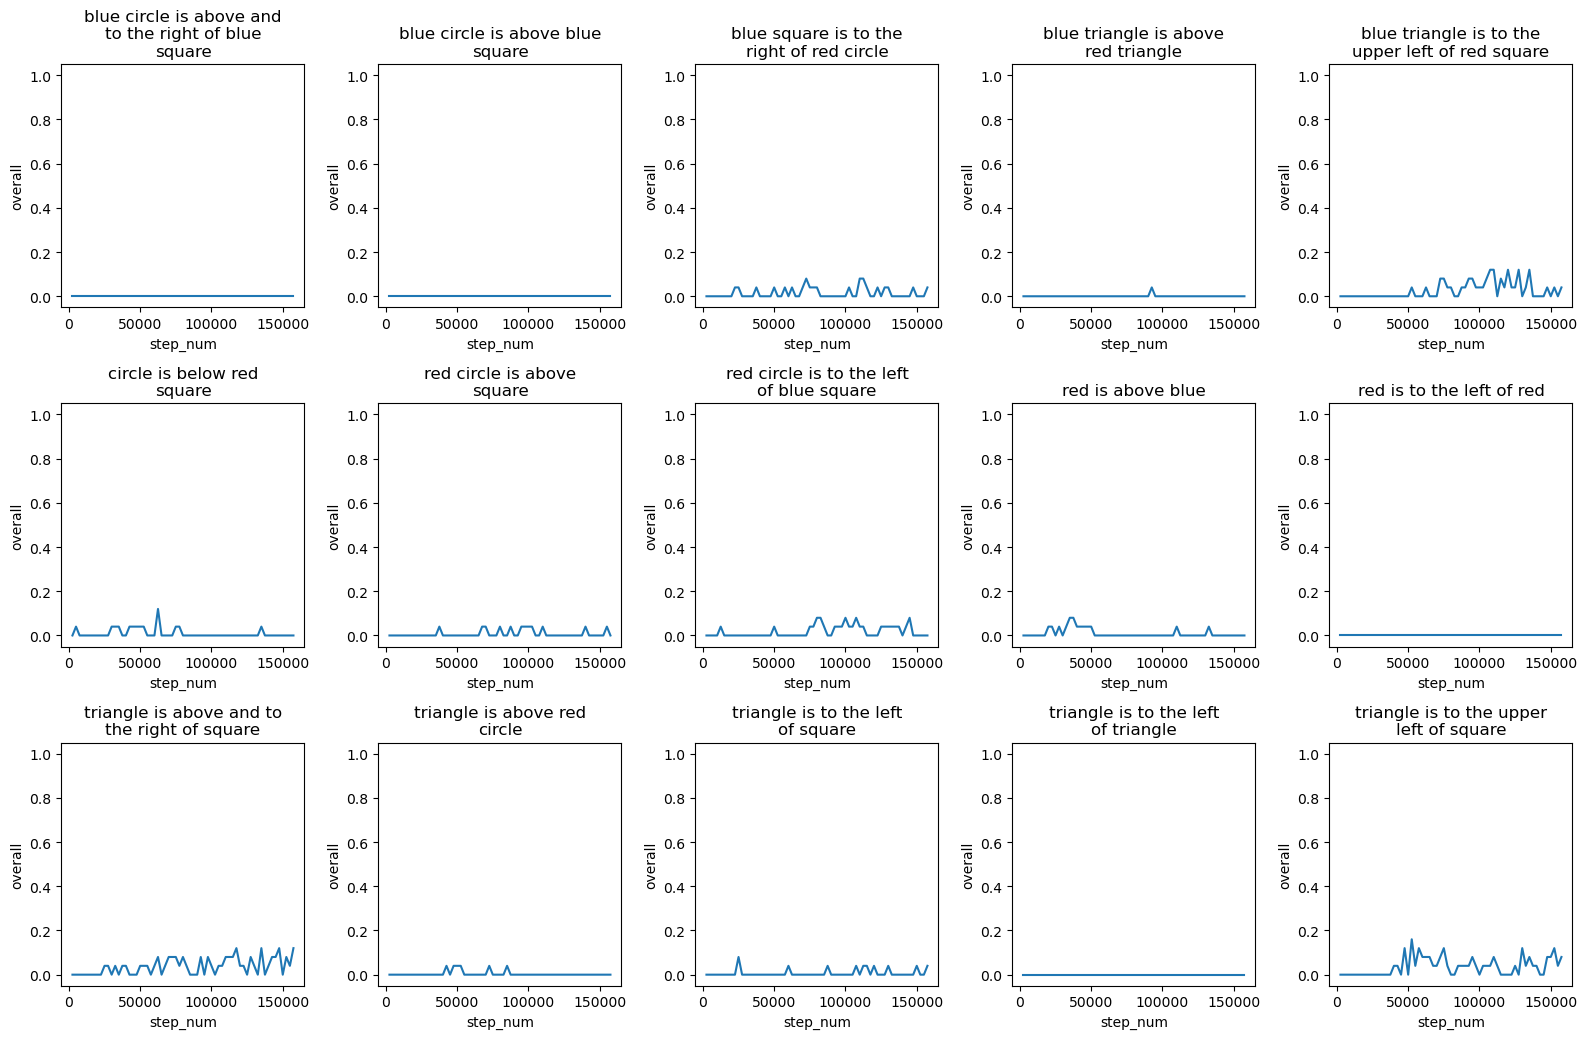

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
# label the hue with prompt names
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"overall": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])
# Create a multi-panel plot
n_prompts = len(prompt_names)
n_cols = 5
n_rows = (n_prompts + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5*n_rows))
axes = axes.flatten()
# Plot each prompt in its own panel
for i, prompt in enumerate(prompt_names):
    prompt_data = score_tab[score_tab["prompt_name"] == prompt]
    sns.lineplot(data=prompt_data, x="step_num", y="overall", ax=axes[i])
    # wrap the title if too long 
    prompt = prompt.replace("_", " ")
    if len(prompt) > 10:
        prompt = "\n".join(textwrap.wrap(prompt, width=25))
    axes[i].set_title(prompt)
    axes[i].set_ylim(-0.05, 1.05)
# Remove empty subplots if any
for i in range(len(prompt_names), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()

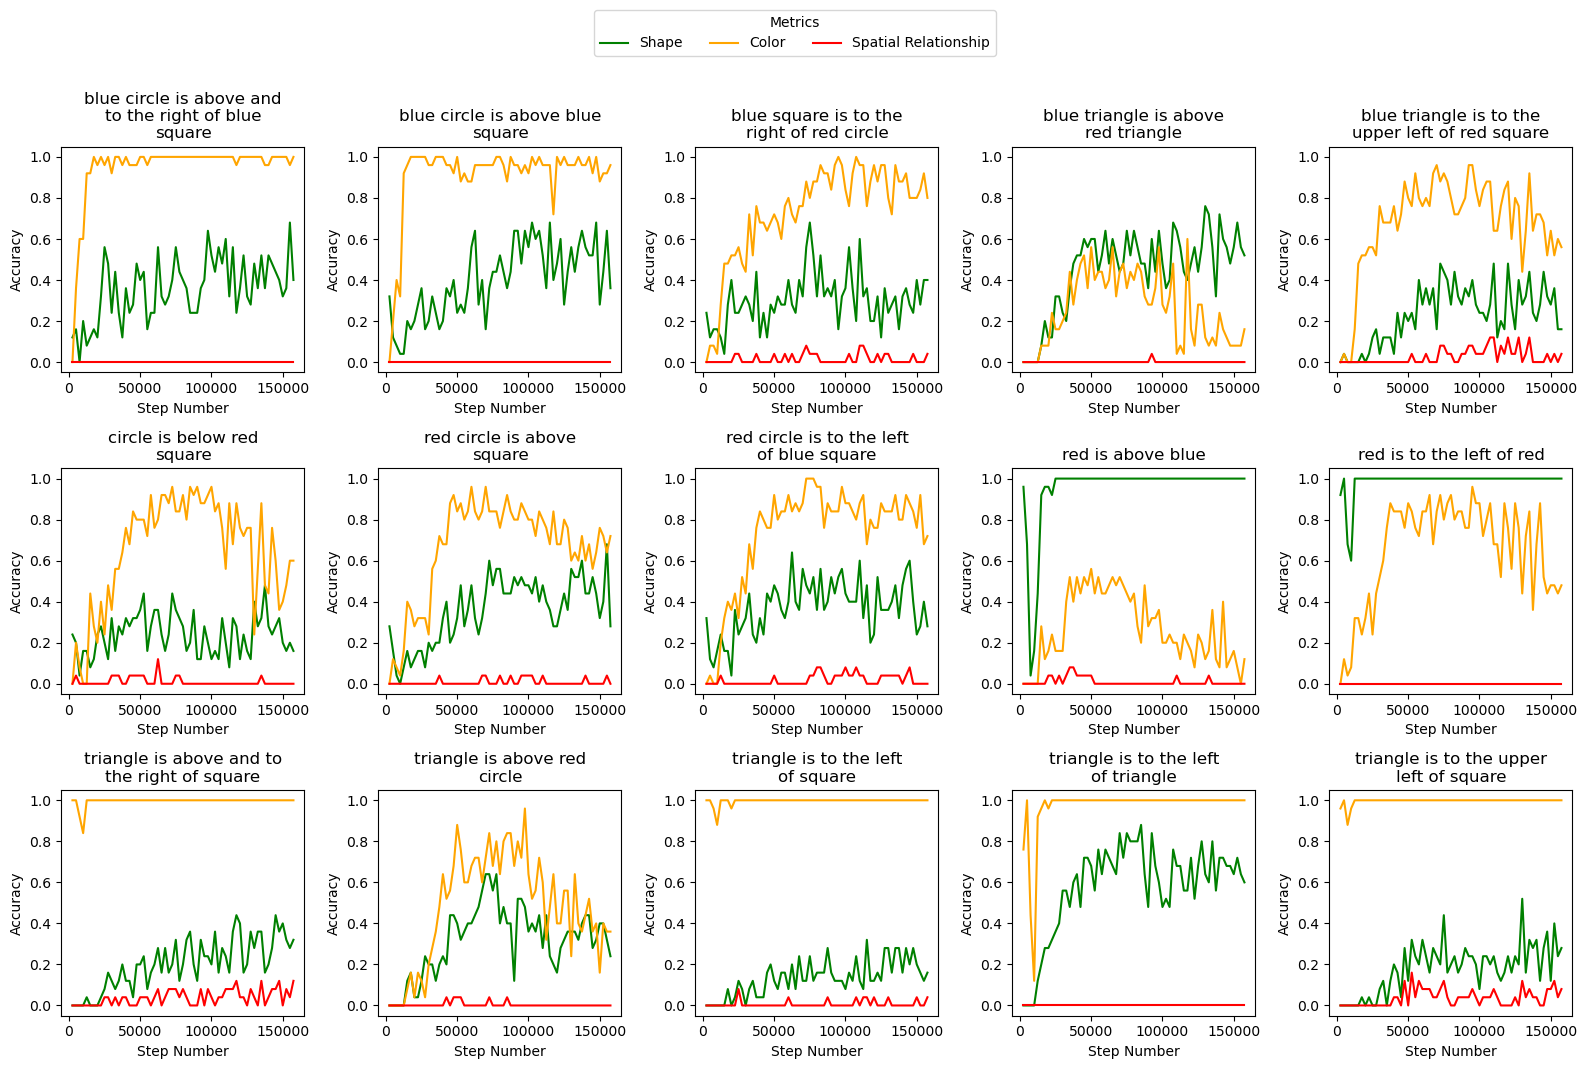

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Aggregate accuracy metrics for each component
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({
    "overall": "mean",
    "shape": "mean",
    "color": "mean",
    "spatial_relationship": "mean"
}).reset_index()

score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])

# Define metrics and their colors
metrics = [ "shape", "color", "spatial_relationship"]
metric_colors = [ "green", "orange", "red"]
metric_titles = [ "Shape", "Color", "Spatial Relationship"]

n_prompts = len(prompt_names)
n_cols = 5
n_rows = (n_prompts + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

# Plot each prompt in its own panel
for i, prompt in enumerate(prompt_names):
    ax = axes[i]
    prompt_data = score_tab[score_tab["prompt_name"] == prompt]
    
    # Plot each metric in the same subplot with different colors
    for metric, color, title in zip(metrics, metric_colors, metric_titles):
        sns.lineplot(data=prompt_data, x="step_num", y=metric, ax=ax, label=title, color=color)
    
    # Wrap the title if too long
    prompt_title = prompt.replace("_", " ")
    if len(prompt_title) > 10:
        prompt_title = "\n".join(textwrap.wrap(prompt_title, width=25))
    
    ax.set_title(prompt_title)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Step Number")
    ax.set_ylabel("Accuracy")
    
    # Remove legends from individual subplots
    ax.legend_ = None

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", fontsize="medium", title="Metrics", ncol=len(metrics), bbox_to_anchor=(0.5, 1.02))

# Remove empty subplots if any
for i in range(len(prompt_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()
